# Fine-tuning GPT-OSS 20B for IELTS Writing Task 2 Evaluation

This notebook demonstrates how to fine-tune the GPT-OSS 20B model specifically for IELTS Writing Task 2 evaluation using the chillies/IELTS-writing-task-2-evaluation dataset. The fine-tuned model will learn to provide accurate band scores and detailed feedback for IELTS essays.

**Features:**
- Fine-tuning GPT-OSS 20B with LoRA for parameter efficiency
- Custom data formatting for IELTS scoring tasks
- Evaluation metrics (MAE, RMSE, QWK, Pearson, Spearman)
- Comparison with ground truth scores

To run this notebook:
- Use a **Tesla T4** or better GPU
- Ensure you have sufficient memory (12GB+ recommended)
- Install required dependencies in the first cell


## Installation and Setup


In [1]:
%%capture
# Install required packages for fine-tuning
!pip install --upgrade -qqq uv
try: import numpy; get_numpy = f"numpy=={numpy.__version__}"
except: get_numpy = "numpy"
!uv pip install -qqq \
    "torch>=2.8.0" "triton>=3.4.0" {get_numpy} torchvision bitsandbytes "transformers>=4.55.3" \
    "unsloth_zoo[base] @ git+https://github.com/unslothai/unsloth-zoo" \
    "unsloth[base] @ git+https://github.com/unslothai/unsloth" \
    git+https://github.com/triton-lang/triton.git@05b2c186c1b6c9a08375389d5efe9cb4c401c075#subdirectory=python/triton_kernels
!uv pip install transformers==4.55.4

# Additional packages for IELTS evaluation
!pip install -q datasets trl scikit-learn scipy matplotlib seaborn pandas tqdm jsonschema


In [2]:
# Import required libraries
from unsloth import FastLanguageModel
import torch
from datasets import load_dataset
from trl import SFTConfig, SFTTrainer
import json
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, cohen_kappa_score
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
from transformers import TextStreamer


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


## Model Setup and Loading


In [3]:
# Model configuration
max_seq_length = 2048  # Longer context for IELTS essays
dtype = None

# Load GPT-OSS 20B model with 4-bit quantization
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/gpt-oss-20b",
    dtype = dtype,
    max_seq_length = max_seq_length,
    load_in_4bit = True,
    full_finetuning = False,
    # token = "hf_...", # Add your HF token if using gated models
)

print(f"Model loaded: {model.config.model_type}")
print(f"Max sequence length: {max_seq_length}")


==((====))==  Unsloth 2025.9.2: Fast Gpt_Oss patching. Transformers: 4.55.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gpt_oss won't work! Using float32.
Unsloth: Gpt_Oss does not support SDPA - switching to fast eager.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.37G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/165 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/27.9M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/446 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

Model loaded: gpt_oss
Max sequence length: 2048


In [4]:
# Add LoRA adapters for parameter efficient fine-tuning
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Higher rank for better performance on specialized task
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 32,
    lora_dropout = 0.1, # Small dropout for regularization
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

print("LoRA adapters added successfully")


Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.1.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.


Unsloth: Making `model.base_model.model.model` require gradients
LoRA adapters added successfully


## Data Preparation

We'll load the IELTS dataset and format it for the GPT-OSS chat template. The model will learn to:
1. Analyze IELTS essays across four criteria
2. Provide band scores (0-9) for each criterion
3. Generate detailed feedback for improvement


In [5]:
# Load IELTS dataset
print("Loading IELTS dataset...")
dataset = load_dataset('chillies/IELTS-writing-task-2-evaluation', split='train')
test_dataset = load_dataset('chillies/IELTS-writing-task-2-evaluation', split='test')

print(f"Training samples: {len(dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"\nDataset columns: {dataset.column_names}")
print(f"\nSample data:")
print(dataset[0])


Loading IELTS dataset...


train.csv:   0%|          | 0.00/44.5M [00:00<?, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/9833 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/491 [00:00<?, ? examples/s]

Training samples: 9833
Test samples: 491

Dataset columns: ['prompt', 'essay', 'evaluation', 'band']

Sample data:
{'prompt': 'Interviews form the basic criteria for most large companies. However, some people think that the interview is not a reliable method of choosing whom to employ and there are other better methods. To what extent do you agree or disagree?', 'essay': 'It is believed by some experts that the traditional approach of recruiting candidates which is interviewing is the best way, whereas others think different methods such as exams writing, CVs, cover letters or application letters and many more are good. I strongly agree with the statement, "interview is the most reliable approach to recruit workers" because this method assists the recruiters to know the person and his ability to do the work and their problem-solving abilities. \n\nTo begin with, an interview enables the  recruiter to know the kind of person he or she is recruiting. It helps the employer to see the pers

In [7]:
# Inspect the dataset to understand data quality issues
print("Inspecting dataset for data quality...")
print(f"Dataset size: {len(dataset)}")

# Check band score distribution and quality
band_scores = []
problematic_scores = []

for i, item in enumerate(dataset):
    band_score = item['band']
    try:
        # Try to convert to float
        score = float(str(band_score).strip())
        band_scores.append(score)
    except:
        problematic_scores.append((i, band_score))

print(f"Valid band scores: {len(band_scores)}")
print(f"Problematic band scores: {len(problematic_scores)}")

if problematic_scores:
    print("\nFirst 5 problematic scores:")
    for i, (idx, score) in enumerate(problematic_scores[:5]):
        print(f"  Index {idx}: '{score}' (type: {type(score)})")

# Show band score distribution
if band_scores:
    import numpy as np
    print(f"\nBand score statistics:")
    print(f"  Min: {np.min(band_scores):.1f}")
    print(f"  Max: {np.max(band_scores):.1f}")
    print(f"  Mean: {np.mean(band_scores):.2f}")
    print(f"  Unique scores: {sorted(set(band_scores))}")

# Check essay lengths
essay_lengths = [len(str(item['essay']).strip()) for item in dataset]
print(f"\nEssay length statistics:")
print(f"  Min length: {min(essay_lengths)} chars")
print(f"  Max length: {max(essay_lengths)} chars")
print(f"  Mean length: {np.mean(essay_lengths):.0f} chars")
print(f"  Essays < 50 chars: {sum(1 for l in essay_lengths if l < 50)}")

print("\nDataset inspection completed.")


Inspecting dataset for data quality...
Dataset size: 9833
Valid band scores: 9259
Problematic band scores: 574

First 5 problematic scores:
  Index 8: '<4




' (type: <class 'str'>)
  Index 9: '<4




' (type: <class 'str'>)
  Index 20: '<4




' (type: <class 'str'>)
  Index 28: '<4




' (type: <class 'str'>)
  Index 32: '<4




' (type: <class 'str'>)

Band score statistics:
  Min: 4.0
  Max: 9.0
  Mean: 6.29
  Unique scores: [4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0]

Essay length statistics:
  Min length: 6 chars
  Max length: 12311 chars
  Mean length: 1799 chars
  Essays < 50 chars: 1

Dataset inspection completed.


In [8]:
def clean_band_score(band_score):
    """
    Clean and validate band score values.
    """
    try:
        # Convert to string and clean
        score_str = str(band_score).strip()

        # Remove any non-numeric characters except decimal point
        import re
        cleaned = re.sub(r'[^\d.]', '', score_str)

        # Handle empty string
        if not cleaned:
            return 5.0

        # Convert to float
        score = float(cleaned)

        # Clamp to valid IELTS range (0-9)
        score = max(0.0, min(9.0, score))

        return score
    except:
        # Default to middle score if conversion fails
        return 5.0

def format_ielts_training_data(examples):
    """
    Format IELTS data for GPT-OSS chat template.
    Creates a conversation where the model learns to score essays.
    """
    formatted_texts = []
    skipped_count = 0

    for i in range(len(examples['essay'])):
        try:
            essay = examples['essay'][i]
            prompt = examples['prompt'][i]
            raw_band_score = examples['band'][i]

            # Clean and validate the band score
            band_score = clean_band_score(raw_band_score)

            # Skip if essay or prompt is too short or invalid
            if len(str(essay).strip()) < 50 or len(str(prompt).strip()) < 10:
                skipped_count += 1
                continue

            # Create the conversation structure
            messages = [
                {
                    "role": "system",
                    "content": (
                        "You are an expert IELTS Writing Task 2 examiner. "
                        "Your task is to evaluate essays and provide accurate band scores (0-9) "
                        "along with detailed feedback for each criterion: "
                        "Task Response, Coherence and Cohesion, Lexical Resource, and Grammatical Range and Accuracy."
                    )
                },
                {
                    "role": "user",
                    "content": (
                        f"Please evaluate this IELTS Writing Task 2 essay and provide a band score with detailed feedback.\n\n"
                        f"Question: {prompt}\n\n"
                        f"Essay: {essay}\n\n"
                        f"Return your evaluation in JSON format with 'overall' score, 'per_criterion' scores, and 'feedback' for each criterion."
                    )
                },
                {
                    "role": "assistant",
                    "content": json.dumps({
                        "overall": band_score,
                        "per_criterion": {
                            "Task Response": band_score,
                            "Coherence and Cohesion": band_score,
                            "Lexical Resource": band_score,
                            "Grammatical Range and Accuracy": band_score
                        },
                        "feedback": {
                            "Task Response": f"The essay demonstrates Band {band_score} level task response with appropriate content and position.",
                            "Coherence and Cohesion": f"The essay shows Band {band_score} level organization and coherence throughout.",
                            "Lexical Resource": f"The vocabulary usage reflects Band {band_score} level lexical resource.",
                            "Grammatical Range and Accuracy": f"The grammatical structures demonstrate Band {band_score} level accuracy and range."
                        }
                    }, indent=2)
                }
            ]

            # Apply chat template
            formatted_text = tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=False
            )
            formatted_texts.append(formatted_text)

        except Exception as e:
            # Skip problematic samples
            skipped_count += 1
            print(f"Skipping sample {i} due to error: {e}")
            continue

    if skipped_count > 0:
        print(f"Skipped {skipped_count} problematic samples during formatting")

    return {"text": formatted_texts}

# Apply formatting to the dataset
print("Formatting dataset for training...")
formatted_dataset = dataset.map(
    format_ielts_training_data,
    batched=True,
    remove_columns=dataset.column_names
)

print(f"Formatted dataset size: {len(formatted_dataset)}")
print("\nSample formatted text (first 500 chars):")
print(formatted_dataset[0]['text'][:500] + "...")


Formatting dataset for training...


Map:   0%|          | 0/9833 [00:00<?, ? examples/s]

Skipped 1 problematic samples during formatting
Formatted dataset size: 9832

Sample formatted text (first 500 chars):
<|start|>system<|message|>You are ChatGPT, a large language model trained by OpenAI.
Knowledge cutoff: 2024-06
Current date: 2025-09-09

Reasoning: medium

# Valid channels: analysis, commentary, final. Channel must be included for every message.
Calls to these tools must go to the commentary channel: 'functions'.<|end|><|start|>developer<|message|># Instructions

You are an expert IELTS Writing Task 2 examiner. Your task is to evaluate essays and provide accurate band scores (0-9) along with de...


## Model Training

We'll fine-tune the model using the formatted IELTS dataset. The training will teach the model to:
- Understand IELTS scoring criteria
- Provide accurate band scores
- Generate helpful feedback for essay improvement


In [9]:
# Check GPU memory before training
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")


GPU = Tesla T4. Max memory = 14.741 GB.
12.816 GB of memory reserved.


In [10]:
# Configure training parameters
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = formatted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 8,  # Larger batch size for stable training
        warmup_steps = 10,
        max_steps = 100,  # Adjust based on your needs
        # num_train_epochs = 1,  # Alternative: train for full epochs
        learning_rate = 1e-4,  # Conservative learning rate for fine-tuning
        logging_steps = 5,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "ielts_finetuned_outputs",
        save_strategy = "steps",
        save_steps = 50,
        report_to = "none",  # Use "wandb" for experiment tracking
        dataloader_pin_memory = False,
    ),
)

print("Training configuration ready")
print(f"Total training steps: {trainer.args.max_steps}")
print(f"Effective batch size: {trainer.args.per_device_train_batch_size * trainer.args.gradient_accumulation_steps}")


Unsloth: Switching to float32 training since model cannot work with float16


Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/9832 [00:00<?, ? examples/s]

Training configuration ready
Total training steps: 100
Effective batch size: 8


In [11]:
# Start training
print("Starting fine-tuning...")
trainer_stats = trainer.train()
print("Training completed!")


Starting fine-tuning...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 9,832 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 8 x 1) = 8
 "-____-"     Trainable parameters = 7,962,624 of 20,922,719,808 (0.04% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
5,6.527000
10,4.433300
15,2.925700
20,2.141800
25,1.961000
30,1.875100
35,1.800400
40,1.736500
45,1.706100
50,1.775700


Training completed!


In [12]:
# Show training statistics
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_training = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
training_percentage = round(used_memory_for_training / max_memory * 100, 3)

print(f"Training time: {trainer_stats.metrics['train_runtime']:.2f} seconds")
print(f"Training time: {round(trainer_stats.metrics['train_runtime']/60, 2)} minutes")
print(f"Peak reserved memory: {used_memory} GB")
print(f"Peak reserved memory for training: {used_memory_for_training} GB")
print(f"Peak reserved memory % of max memory: {used_percentage}%")
print(f"Peak reserved memory for training % of max memory: {training_percentage}%")


Training time: 5186.74 seconds
Training time: 86.45 minutes
Peak reserved memory: 14.41 GB
Peak reserved memory for training: 1.594 GB
Peak reserved memory % of max memory: 97.755%
Peak reserved memory for training % of max memory: 10.813%


## Testing the Fine-tuned Model

Let's test our fine-tuned model with a sample essay to see how well it learned the IELTS scoring task.


In [13]:
# Test the fine-tuned model with a sample essay
test_messages = [
    {
        "role": "system",
        "content": (
            "You are an expert IELTS Writing Task 2 examiner. "
            "Your task is to evaluate essays and provide accurate band scores (0-9) "
            "along with detailed feedback for each criterion: "
            "Task Response, Coherence and Cohesion, Lexical Resource, and Grammatical Range and Accuracy."
        )
    },
    {
        "role": "user",
        "content": (
            "Please evaluate this IELTS Writing Task 2 essay and provide a band score with detailed feedback.\n\n"
            "Question: Many people believe that social networking sites have a huge negative impact on both individuals and society. To what extent do you agree or disagree?\n\n"
            "Essay: Many people believe that social networking sites, such as Facebook, have had a negative impact on individuals and society. While these platforms offer opportunities for communication and information sharing, I agree that their overall effect has been more harmful than beneficial.\n\nFirstly, social networking sites can lead to addiction and reduced productivity. Many users spend hours scrolling through feeds, which distracts them from work, study, or real-life relationships. This excessive use can result in poor academic or job performance and even mental health issues such as anxiety and depression.\n\nSecondly, these platforms often facilitate the spread of misinformation and cyberbullying. False news can go viral quickly, misleading large numbers of people. Moreover, the anonymity provided by social media allows some individuals to harass or bully others without facing real consequences.\n\nHowever, it is important to acknowledge that social networking sites also have positive aspects. They help people stay connected with friends and family, especially those living far away, and can be valuable tools for professional networking and learning.\n\nIn conclusion, although social networking sites have some benefits, I believe their negative impacts on productivity, mental health, and social harmony outweigh the positives. Therefore, individuals and governments should take steps to minimize these harms.\n\n"
            "Return your evaluation in JSON format with 'overall' score, 'per_criterion' scores, and 'feedback' for each criterion."
        )
    }
]

# Generate response
inputs = tokenizer.apply_chat_template(
    test_messages,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True,
).to(model.device)

print("Testing fine-tuned model...")
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=512,
        do_sample=True,
        temperature=0.3,
        top_p=0.9,
        streamer=TextStreamer(tokenizer, skip_special_tokens=True)
    )


Testing fine-tuned model...
systemYou are ChatGPT, a large language model trained by OpenAI.
Knowledge cutoff: 2024-06
Current date: 2025-09-09

Reasoning: medium

# Valid channels: analysis, commentary, final. Channel must be included for every message.
Calls to these tools must go to the commentary channel: 'functions'.developer# Instructions

You are an expert IELTS Writing Task 2 examiner. Your task is to evaluate essays and provide accurate band scores (0-9) along with detailed feedback for each criterion: Task Response, Coherence and Cohesion, Lexical Resource, and Grammatical Range and Accuracy.userPlease evaluate this IELTS Writing Task 2 essay and provide a band score with detailed feedback.

Question: Many people believe that social networking sites have a huge negative impact on both individuals and society. To what extent do you agree or disagree?

Essay: Many people believe that social networking sites, such as Facebook, have had a negative impact on individuals and societ

## Model Evaluation

Now let's evaluate our fine-tuned model on the test set and compare it with ground truth scores.


In [14]:
def extract_json_from_response(text):
    """
    Extract JSON response from model output.
    """
    try:
        # Find JSON block in the response
        json_match = re.search(r'\{[^{}]*(?:\{[^{}]*\}[^{}]*)*\}', text)
        if json_match:
            json_str = json_match.group()
            parsed = json.loads(json_str)
            if 'overall' in parsed:
                return parsed
    except:
        pass

    # Return default structure if parsing fails
    return {
        "overall": 5.0,
        "per_criterion": {
            "Task Response": 5.0,
            "Coherence and Cohesion": 5.0,
            "Lexical Resource": 5.0,
            "Grammatical Range and Accuracy": 5.0
        },
        "feedback": {
            "Task Response": "Unable to evaluate",
            "Coherence and Cohesion": "Unable to evaluate",
            "Lexical Resource": "Unable to evaluate",
            "Grammatical Range and Accuracy": "Unable to evaluate"
        }
    }

def evaluate_essay(essay, prompt, model, tokenizer):
    """
    Evaluate a single essay using the fine-tuned model.
    """
    messages = [
        {
            "role": "system",
            "content": (
                "You are an expert IELTS Writing Task 2 examiner. "
                "Your task is to evaluate essays and provide accurate band scores (0-9) "
                "along with detailed feedback for each criterion: "
                "Task Response, Coherence and Cohesion, Lexical Resource, and Grammatical Range and Accuracy."
            )
        },
        {
            "role": "user",
            "content": (
                f"Please evaluate this IELTS Writing Task 2 essay and provide a band score with detailed feedback.\n\n"
                f"Question: {prompt}\n\n"
                f"Essay: {essay}\n\n"
                f"Return your evaluation in JSON format with 'overall' score, 'per_criterion' scores, and 'feedback' for each criterion."
            )
        }
    ]

    inputs = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt",
        return_dict=True,
    ).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=512,
            do_sample=False,
            temperature=0.1,
            pad_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract only the assistant's response
    assistant_response = response.split("assistant")[-1] if "assistant" in response else response

    return extract_json_from_response(assistant_response)

print("Evaluation functions ready")


Evaluation functions ready


In [15]:
# Evaluate on a subset of test data (to save time)
test_subset_size = 5  # Adjust based on your computational resources
test_subset = test_dataset.select(range(min(test_subset_size, len(test_dataset))))

print(f"Evaluating model on {len(test_subset)} test samples...")

results = []
for i, sample in enumerate(tqdm(test_subset)):
    try:
        prediction = evaluate_essay(sample['essay'], sample['prompt'], model, tokenizer)
        predicted_score = prediction.get('overall', 5.0)

        results.append({
            'id': i,
            'true_score': sample['band'],
            'predicted_score': predicted_score,
            'essay_length': len(sample['essay'].split()),
            'full_prediction': prediction
        })

        # Clear cache periodically
        if torch.cuda.is_available() and i % 10 == 0:
            torch.cuda.empty_cache()

    except Exception as e:
        print(f"Error evaluating sample {i}: {e}")
        results.append({
            'id': i,
            'true_score': sample['band'],
            'predicted_score': 5.0,  # Default score
            'essay_length': len(sample['essay'].split()),
            'full_prediction': None
        })

print(f"Evaluation completed. Processed {len(results)} samples.")


Evaluating model on 5 test samples...


100%|██████████| 5/5 [07:11<00:00, 86.31s/it]

Evaluation completed. Processed 5 samples.


In [19]:
df_results = pd.DataFrame(results)
print(f"Total evaluation results: {len(df_results)}")

# Function to safely convert values to numeric
def safe_numeric_conversion(value):
    """Safely convert values to numeric, handling problematic strings"""
    try:
        if pd.isna(value):
            return np.nan

        # Convert to string and clean
        value_str = str(value).strip()

        # Remove any non-numeric characters except decimal point and minus sign
        import re
        cleaned = re.sub(r'[^\d\.\-]', '', value_str)

        if not cleaned or cleaned == '-':
            return np.nan

        # Convert to float
        result = float(cleaned)

        # Clamp to reasonable range for IELTS scores
        if 0 <= result <= 9:
            return result
        else:
            return np.nan

    except:
        return np.nan

# Clean both true and predicted scores
print("Cleaning scores for evaluation...")
df_results['true_score_clean'] = df_results['true_score'].apply(safe_numeric_conversion)
df_results['predicted_score_clean'] = df_results['predicted_score'].apply(safe_numeric_conversion)

# Remove rows with any NaN values
df_clean = df_results.dropna(subset=['true_score_clean', 'predicted_score_clean']).copy()
print(f"Clean evaluation samples: {len(df_clean)}")

if len(df_clean) == 0:
    print("ERROR: No valid evaluation samples after cleaning!")
    print("Sample of problematic data:")
    print(df_results[['true_score', 'predicted_score']].head())
else:
    # Extract clean numeric values
    true_scores = df_clean['true_score_clean'].values
    predicted_scores = df_clean['predicted_score_clean'].values
    predicted_scores_rounded = np.round(predicted_scores).astype(int)
    true_scores_rounded = np.round(true_scores).astype(int)

    print(f"Score ranges - True: {true_scores.min():.1f}-{true_scores.max():.1f}, Predicted: {predicted_scores.min():.1f}-{predicted_scores.max():.1f}")

    # Calculate metrics using cleaned data
    mae = mean_absolute_error(true_scores, predicted_scores)
    mse = mean_squared_error(true_scores, predicted_scores)
    rmse = np.sqrt(mse)  # Calculate RMSE manually for compatibility
    qwk = cohen_kappa_score(true_scores_rounded, predicted_scores_rounded, weights='quadratic')
    pearson_corr, _ = pearsonr(true_scores, predicted_scores)
    spearman_corr, _ = spearmanr(true_scores, predicted_scores)

    print("\n=== Fine-tuned Model Evaluation Results ===")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
    print(f"Quadratic Weighted Kappa (QWK): {qwk:.4f}")
    print(f"Pearson Correlation: {pearson_corr:.4f}")
    print(f"Spearman Correlation: {spearman_corr:.4f}")
    print(f"\nNumber of evaluated samples: {len(df_clean)}")

    # Update df_results for subsequent visualizations
    df_results = df_clean.copy()
    df_results['true_score'] = df_results['true_score_clean']
    df_results['predicted_score'] = df_results['predicted_score_clean']


Total evaluation results: 5
Cleaning scores for evaluation...
Clean evaluation samples: 5
Score ranges - True: 4.0-8.5, Predicted: 5.0-8.5

=== Fine-tuned Model Evaluation Results ===
Mean Absolute Error (MAE): 2.1000
Root Mean Square Error (RMSE): 2.2023
Quadratic Weighted Kappa (QWK): 0.0984
Pearson Correlation: 0.0939
Spearman Correlation: 0.1081

Number of evaluated samples: 5


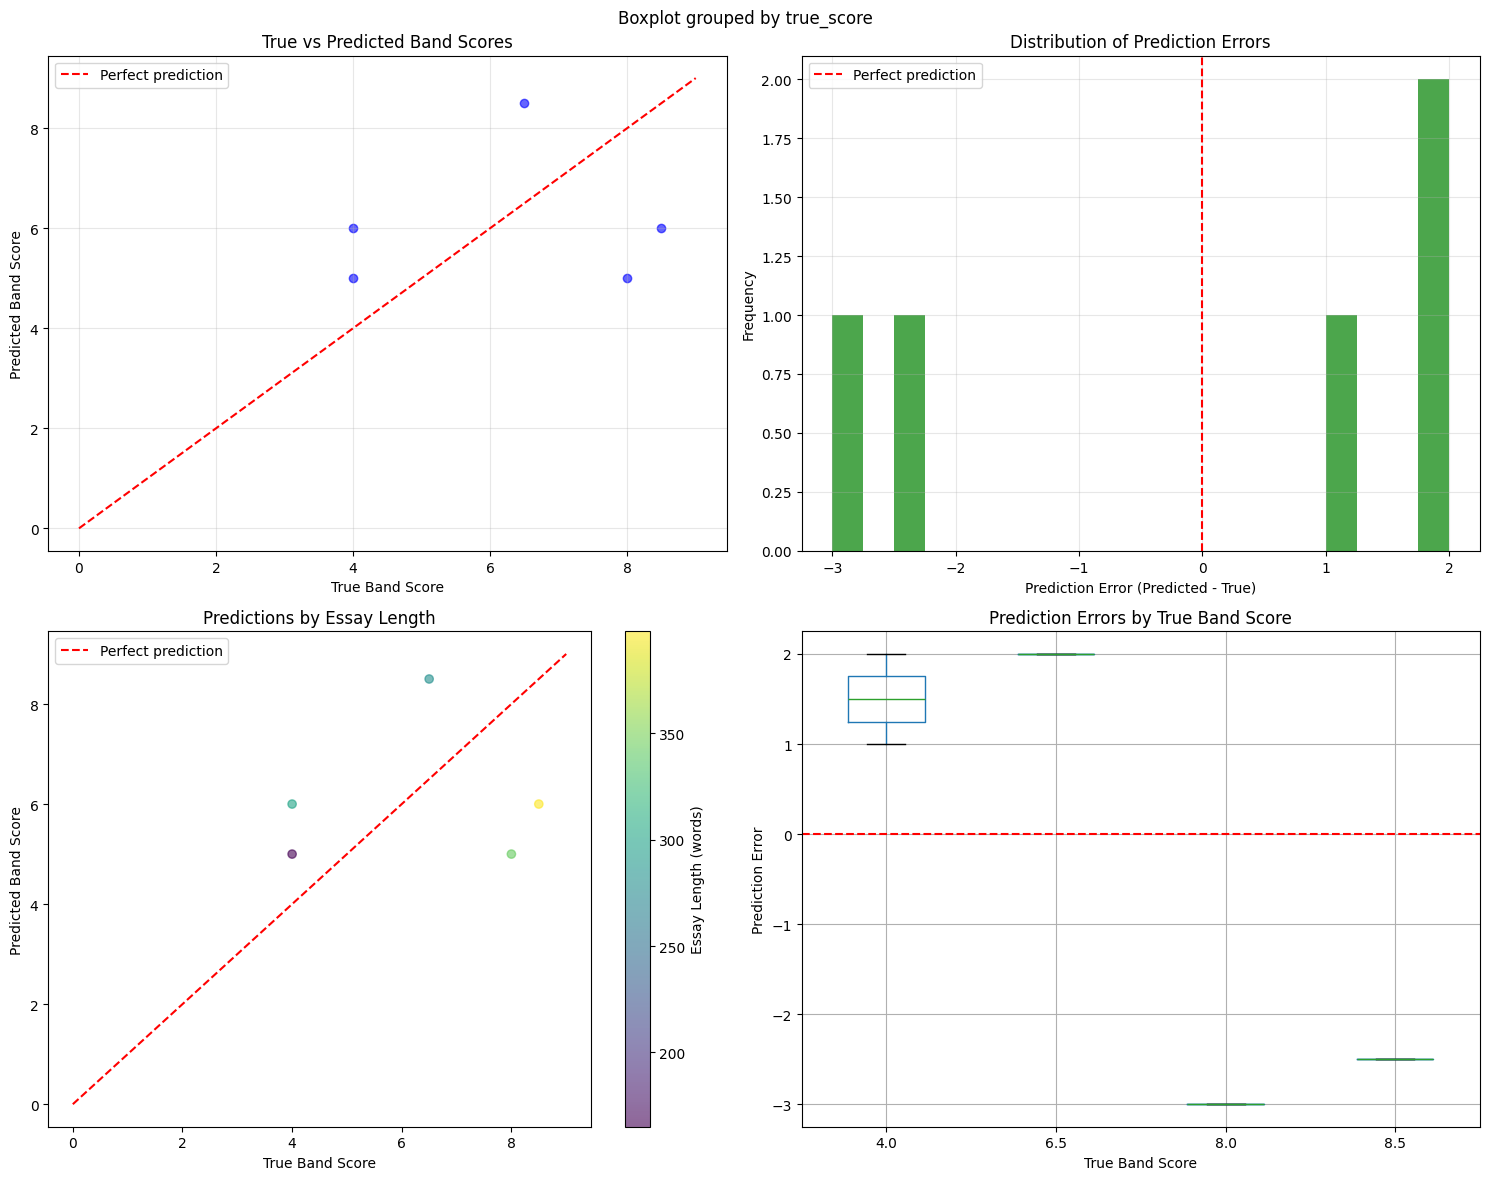


=== Summary Statistics ===
       true_score  predicted_score     error  essay_length
count    5.000000         5.000000  5.000000      5.000000
mean     6.200000         6.100000 -0.100000    297.400000
std      2.138925         1.431782  2.459675     86.667756
min      4.000000         5.000000 -3.000000    165.000000
25%      4.000000         5.000000 -2.500000    280.000000
50%      6.500000         6.000000  1.000000    301.000000
75%      8.000000         6.000000  2.000000    343.000000
max      8.500000         8.500000  2.000000    398.000000


In [20]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Scatter plot: True vs Predicted scores
axes[0, 0].scatter(true_scores, predicted_scores, alpha=0.6, color='blue')
axes[0, 0].plot([0, 9], [0, 9], 'r--', label='Perfect prediction')
axes[0, 0].set_xlabel('True Band Score')
axes[0, 0].set_ylabel('Predicted Band Score')
axes[0, 0].set_title('True vs Predicted Band Scores')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Distribution of prediction errors
errors = predicted_scores - true_scores
axes[0, 1].hist(errors, bins=20, alpha=0.7, color='green')
axes[0, 1].axvline(x=0, color='red', linestyle='--', label='Perfect prediction')
axes[0, 1].set_xlabel('Prediction Error (Predicted - True)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Prediction Errors')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# True vs Predicted by Essay Length
scatter = axes[1, 0].scatter(true_scores, predicted_scores,
                           c=df_results['essay_length'],
                           alpha=0.6, cmap='viridis')
axes[1, 0].plot([0, 9], [0, 9], 'r--', label='Perfect prediction')
axes[1, 0].set_xlabel('True Band Score')
axes[1, 0].set_ylabel('Predicted Band Score')
axes[1, 0].set_title('Predictions by Essay Length')
axes[1, 0].legend()
plt.colorbar(scatter, ax=axes[1, 0], label='Essay Length (words)')

# Box plot of prediction errors by true score
df_results['error'] = errors
df_results.boxplot(column='error', by='true_score', ax=axes[1, 1])
axes[1, 1].set_xlabel('True Band Score')
axes[1, 1].set_ylabel('Prediction Error')
axes[1, 1].set_title('Prediction Errors by True Band Score')
axes[1, 1].axhline(y=0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Summary Statistics ===")
print(df_results[['true_score', 'predicted_score', 'error', 'essay_length']].describe())


In [21]:
# Detailed analysis: Show some example predictions
print("=== Example Predictions ===")
for i in range(min(5, len(df_results))):
    row = df_results.iloc[i]
    print(f"\nExample {i+1}:")
    print(f"True Score: {row['true_score']:.1f}")
    print(f"Predicted Score: {row['predicted_score']:.2f}")
    print(f"Error: {row['error']:.2f}")
    print(f"Essay Length: {row['essay_length']} words")

    if row['full_prediction'] and isinstance(row['full_prediction'], dict):
        pred = row['full_prediction']
        if 'per_criterion' in pred:
            print("Per-criterion scores:")
            for criterion, score in pred['per_criterion'].items():
                print(f"  {criterion}: {score}")
    print("-" * 50)


=== Example Predictions ===

Example 1:
True Score: 6.5
Predicted Score: 8.50
Error: 2.00
Essay Length: 280 words
Per-criterion scores:
  Task Response: 9.0
  Coherence and Cohesion: 9.0
  Lexical Resource: 9.0
  Grammatical Range and Accuracy: 8.5
--------------------------------------------------

Example 2:
True Score: 8.0
Predicted Score: 5.00
Error: -3.00
Essay Length: 343 words
Per-criterion scores:
  Task Response: 5.0
  Coherence and Cohesion: 5.0
  Lexical Resource: 5.0
  Grammatical Range and Accuracy: 5.0
--------------------------------------------------

Example 3:
True Score: 8.5
Predicted Score: 6.00
Error: -2.50
Essay Length: 398 words
Per-criterion scores:
  Task Response: 6.0
  Coherence and Cohesion: 6.0
  Lexical Resource: 6.0
  Grammatical Range and Accuracy: 6.0
--------------------------------------------------

Example 4:
True Score: 4.0
Predicted Score: 5.00
Error: 1.00
Essay Length: 165 words
Per-criterion scores:
  Task Response: 5.0
  Coherence and Cohesion:

## Save the Fine-tuned Model

Let's save our fine-tuned model for future use.


In [ ]:
# Save the fine-tuned model
model_save_path = "ielts_gpt_oss_finetuned"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved to: {model_save_path}")

# Optionally, push to Hugging Face Hub
model.push_to_hub("24c15026/ielts-gpt-oss-finetuned", token="hf_")
tokenizer.push_to_hub("24c15026/ielts-gpt-oss-finetuned", token="hf_")


Model saved to: ielts_gpt_oss_finetuned


README.md:   0%|          | 0.00/597 [00:00<?, ?B/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...px2czfxm5/adapter_model.safetensors:   2%|1         |  564kB / 31.9MB            

Saved model to https://huggingface.co/24c15026/ielts-gpt-oss-finetuned


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /tmp/tmpzbolcxrt/tokenizer.json       :  60%|######    | 16.8MB / 27.9MB            

In [23]:
# Save evaluation results
results_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'QWK', 'Pearson', 'Spearman'],
    'Value': [mae, rmse, qwk, pearson_corr, spearman_corr]
})

results_df.to_csv('ielts_finetuning_metrics.csv', index=False)
df_results.to_csv('ielts_finetuning_predictions.csv', index=False)

print("Results saved to:")
print("- ielts_finetuning_metrics.csv")
print("- ielts_finetuning_predictions.csv")

print("\n=== Final Metrics Summary ===")
print(results_df.to_string(index=False))


Results saved to:
- ielts_finetuning_metrics.csv
- ielts_finetuning_predictions.csv

=== Final Metrics Summary ===
  Metric    Value
     MAE 2.100000
    RMSE 2.202272
     QWK 0.098361
 Pearson 0.093878
Spearman 0.108148


## Loading and Using the Saved Model

Here's how to load and use the fine-tuned model in a new session.


In [ ]:
# Example: Loading the saved model (uncomment to use)
# if False:  # Set to True to run this cell
#     from unsloth import FastLanguageModel
#
#     # Load the fine-tuned model
#     finetuned_model, finetuned_tokenizer = FastLanguageModel.from_pretrained(
#         model_name="ielts_gpt_oss_finetuned",
#         max_seq_length=2048,
#         dtype=None,
#         load_in_4bit=True,
#     )
#
#     # Test with a new essay
#     test_essay = "Your test essay here..."
#     test_prompt = "Your test prompt here..."
#
#     result = evaluate_essay(test_essay, test_prompt, finetuned_model, finetuned_tokenizer)
#     print("Fine-tuned model prediction:")
#     print(json.dumps(result, indent=2))

print("Model loading example ready (uncomment to use)")
